# Stream Clustering

In [1]:
from scripts.preprocess_data import *
from scripts.preprocess_lemmatizer import preprocess_lemmatizer
from river import cluster
from river import stream
from river import feature_extraction
from river import compose
import nltk
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arneh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arneh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arneh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = load_data()
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df['minute_of_day'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
length = df.shape[0]
df_sub = df.iloc[:length]


In [3]:
preprocessed_text_sub = [ preprocess_lemmatizer(tweet)for tweet in df_sub['text']]


In [46]:
text_clust_algo = cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=False,
    radius=0.9, num_macro = 10)

stopwords = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I']

In [47]:
model = compose.Pipeline(
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=stopwords),
    text_clust_algo,
)

In [18]:
import pandas as pd

text_clust_algo = cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=False,
    radius=0.6)
stopwords = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I']
model = compose.Pipeline(
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=stopwords),
    text_clust_algo,
)
nstart = 0
i = 0
old_time = df_sub.loc[i, 'minute_of_day']
log = []
micro_clusters = text_clust_algo.micro_clusters
print("running")
for text in preprocessed_text_sub:
    if i % 5000 == 0:
        print(f"Iteration: {nstart+i}")
    model.learn_one(text)
    if df_sub.loc[i, 'minute_of_day'] != old_time:
        old_time = df_sub.loc[i, 'minute_of_day']
        micro_clusters = text_clust_algo.micro_clusters
        for key, micro_cluster in micro_clusters.items():
            weight = micro_cluster.weight
            log.append({'minute_of_day': old_time, 'micro_cluster_id': key, 'weight': weight, 'terms': [term[0] for term in list(micro_cluster.tf.items())], 'cluster_size': len(micro_cluster.tf.items())})
    i += 1
log_df = pd.DataFrame(log)


running
Iteration: 0
Iteration: 5000
Iteration: 10000
Iteration: 15000
Iteration: 20000
Iteration: 25000
Iteration: 30000
Iteration: 35000
Iteration: 40000
Iteration: 45000
Iteration: 50000
Iteration: 55000
Iteration: 60000
Iteration: 65000
Iteration: 70000


In [6]:
log_df.head()

,minute_of_day,micro_cluster_id,weight,terms,cluster_size
0,1,0,1.0,"[running, business, mean, juggling, countless,...",35
1,1,1,1.0,"[liz, truss, walking, lingering, shadow, prede...",23
2,1,2,1.0,"[uk, bracing, war, government, building, londo...",31
3,1,3,1.0,"[marrying, second, third, cousin, removed, isn...",35
4,1,4,1.0,"[truly, disgraceful, indian, national, congres...",25


In [50]:

high_weight_ids = log_df[log_df['weight'] > 40]['micro_cluster_id'].unique().tolist()
high_weight_ids

[67, 1722, 18108, 31535, 36366, 43739, 89]

C:\Users\arneh\AppData\Local\Temp\ipykernel_12584\2376461783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df['micro_cluster_name'] = filtered_log_df['micro_cluster_id'].map(microcluster_names).fillna(filtered_log_df['micro_cluster_id'].astype(str))


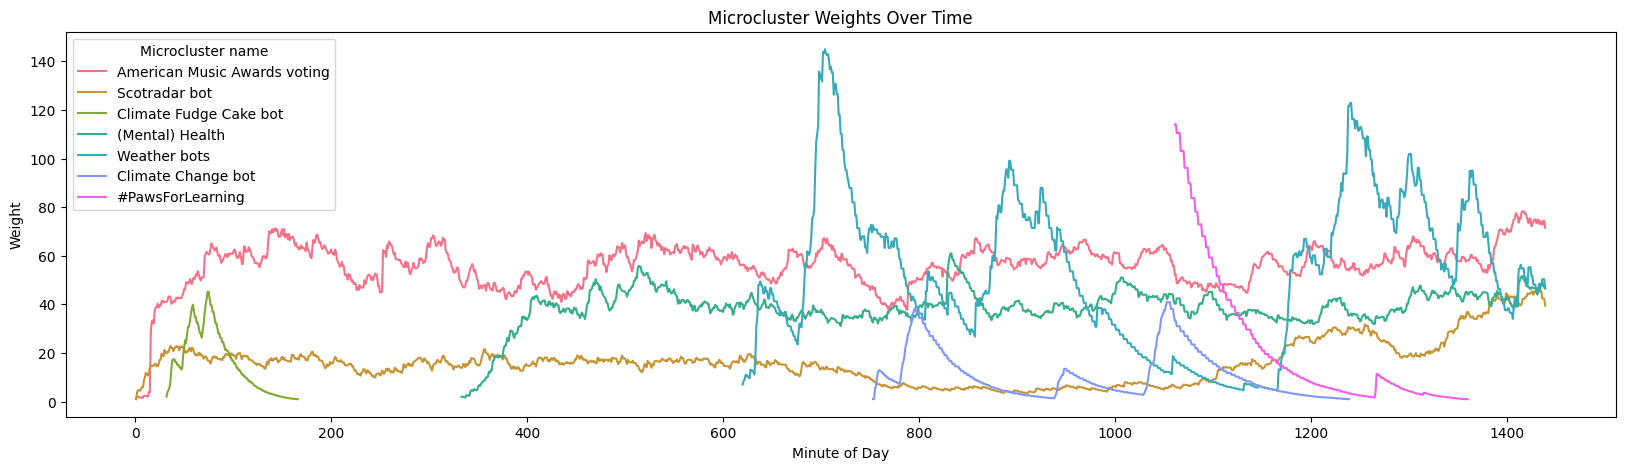

In [49]:
import seaborn as sns

# Filter the log_df for the important microcluster ids
filtered_log_df = log_df[log_df['micro_cluster_id'].isin(high_weight_ids)]

# Plot the data
plt.figure(figsize=(20, 5))
palette = sns.color_palette("husl", len(high_weight_ids))
#sns.lineplot(data=filtered_log_df, x='minute_of_day', y='weight', hue='micro_cluster_id', palette=palette)
# Define a mapping of microcluster IDs to names
microcluster_names = {
    67: 'American Music Awards voting',
    89: 'Scotradar bot',
    1722: 'Climate Fudge Cake bot',
    18108: '(Mental) Health',
    31535: 'Weather bots',
    36366: 'Climate Change bot',
    43739: '#PawsForLearning'
}

# Map the microcluster IDs to names
filtered_log_df['micro_cluster_name'] = filtered_log_df['micro_cluster_id'].map(microcluster_names).fillna(filtered_log_df['micro_cluster_id'].astype(str))

# Plot the data with names
sns.lineplot(data=filtered_log_df, x='minute_of_day', y='weight', hue='micro_cluster_name', palette=palette)
plt.xlabel('Minute of Day')
plt.ylabel('Weight')
plt.title('Microcluster Weights Over Time')
plt.legend(title='Microcluster name')
plt.show()


We analyzed the clusters and their development with the Visual Studio Coode extension Data Wrangler. To understand where our results are coming from we replicate some parts of our analysis steps below with Python code.

In [33]:
log_df[log_df["micro_cluster_id"] == 67].iloc[list(range(0,9)) + list(range(200, 220)) + list(range(400, 420)) + list(range(1000, 1010))]



,minute_of_day,micro_cluster_id,weight,terms,cluster_size
67,1,67,1.000000,"[glopez, peter, jbrown, mflores, yhawkins, tim...",42
160,2,67,1.885024,"[yhawkins, amydaniels, ericbarnes, energy, unr...",36
270,3,67,1.846231,"[yhawkins, amydaniels, ericbarnes, energy, unr...",36
407,4,67,1.846231,"[yhawkins, amydaniels, ericbarnes, energy, unr...",36
597,5,67,1.722595,[yhawkins],1
758,6,67,1.607238,[yhawkins],1
884,7,67,1.607238,[yhawkins],1
1061,8,67,1.499606,[yhawkins],1
1204,9,67,2.394460,"[yhawkins, peter, get, ready, army, th, term, ...",36
33623,201,67,61.036800,"[yhawkins, voting, btsbbmas, army, time, show,...",204
